<!-- Badges: -->
[![License](https://img.shields.io/github/license/QuCAI-Lab/ibm2022-quantum-spring-challenge.svg?logo=CreativeCommons&style=flat-square)](https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge/blob/dev/LICENSE.md)
[![Contributions](https://img.shields.io/badge/contributions-welcome-orange?style=flat-square)](https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge/pulls)
[![Maintenance](https://img.shields.io/badge/Maintained%3F-yes-green.svg)](https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge/graphs/commit-activity)
[![Release](https://img.shields.io/github/release/QuCAI-Lab/ibm2022-quantum-spring-challenge.svg)](https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge/releases)


<!-- Title: -->
<div align="center">
  <h1> Supplementary Material for IBM Quantum Spring Challenge 2022 </h1>
</div>

<!-- Author: -->
<div align="center">
  <b>Author: <a target="_blank" href="https://github.com/camponogaraviera" rel="noopener noreferrer">Lucas Camponogara Viera</a></b>
</div>

<div align='center'>
<table class="tfo-notebook-buttons" align="head">
  <td>
    <a target="_blank" href="https://github.com/QuCAI-Lab/ibm2022-quantum-spring-challenge"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /></a>
  </td>
</table>
</div>

---
This notebook consists of the step-by-step derivations of the quantum circuits provided as solutions to the first challenge. In addition, useful linear algebra identities are verified using index notation, NumPy, SymPy and Qiskit SDK. 

---

In [ ]:
%autosave 60

Autosaving every 60 seconds


In [ ]:
#!pip install qiskit

In [ ]:
#!pip install pylatexenc # Ps: restart the runtime after installation.

In [ ]:
import numpy as np
import sympy as sym
from sympy.physics.quantum import TensorProduct
from qiskit import Aer, QuantumRegister, QuantumCircuit, assemble
from qiskit.quantum_info import Statevector
import pylatexenc # Required to use 'MatplotlibDrawer'.

# Definitions

- Defining the eigenstates, projector operators, and gates that will be used to demonstrate the identites.

In [ ]:
'''Eigenstates of the Pauli-Z gate (Z-basis):'''
zero=np.array([[1,0]]) # A 2-D row-like (bra vector) numpy array representing the classical state <0|.
one=np.array([[0,1]])  # A 2-D row-like (bra vector) numpy array representing the classical state <1|.

'''Eigenstates of the Pauli-X gate (X-basis):'''
plus=1/(np.sqrt(2))*(zero+one)      # 2-D row-like numpy array (bra vector) representing the superposition state <+| = 1/[sqrt(2)](<0| + <1|).
minus=1/(np.sqrt(2))*(zero-one)     # 2-D row-like numpy array (bra vector) representing the superposition state <-| = 1/[sqrt(2)](<0| - <1|).
oplus=1/(np.sqrt(2))*(zero+1j*one)  # 2-D row-like numpy array (bra vector) representing the superposition state <⊕| = 1/[sqrt(2)](<0| + i<1|).
ominus=1/(np.sqrt(2))*(zero-1j*one) # 2-D row-like numpy array (bra vector) representing the superposition state <⊖| = 1/[sqrt(2)](<0| - i<1|).

'''Projector operators of the ZZ gate:'''
#zeros=np.outer(np.kron(zero,zero),np.kron(zero,zero)) # Matrix of the outer product |00><00|.
#ones=np.outer(np.kron(one,one),np.kron(one,one))      # Matrix of the outer product |11><11|.
#zerone=np.outer(np.kron(zero,one),np.kron(zero,one))  # Matrix of the outer product |01><01|.
#onezero=np.outer(np.kron(one,zero),np.kron(one,zero)) # Matrix of the outer product |10><10|.
zeros=np.kron(zero.T,zero.T)@np.kron(zero,zero) # Matrix of the outer product |00><00|.
ones=np.kron(one.T,one.T)@np.kron(one,one)      # Matrix of the outer product |11><11|.
zerone=np.kron(zero.T,one.T)@np.kron(zero,one)  # Matrix of the outer product |01><01|.
onezero=np.kron(one.T,zero.T)@np.kron(one,zero) # Matrix of the outer product |10><10|.

'''1-qubit gates SU(2):'''
had = (1/np.sqrt(2))*np.array([[1,1],[1,-1]]) # Matrix of the Hadamard gate that performs a Pi radian rotation around an axis between the x and z axes.
phase = np.array([[1,0],[0,1j]]) #  Matrix of the Phase gate S = P(pi/2) = square-root of Pauli-Z.
sigma0 = np.identity(2) # Matrix of the identity gate.
sigma1 = np.array([[0,1],[1,0]], dtype=(np.float32)) # Matrix of the Pauli-X gate that performs a Pi radian rotation around the x-axis.
sigma2 = np.array([[0,-1j],[1j,0]], dtype=(np.complex64)) # Matrix of the Pauli-Y gate = iXZ.
sigma3 = np.array([[1,0],[0,-1]], dtype=(np.float32)) # Matrix of the Pauli-Z gate = P(pi).

'''2-qubit gates SU(2x2):'''
XX = np.kron(sigma1,sigma1) # Matrix of the XX gate.
YY = np.kron(sigma2,sigma2) # Matrix of the YY gate.

'''Array dimensions:'''
zero.shape, one.shape, plus.shape, minus.shape, oplus.shape, ominus.shape, zeros.shape, ones.shape, zerone.shape, onezero.shape, had.shape, phase.shape, sigma0.shape, sigma1.shape, sigma2.shape, sigma3.shape, XX.shape, YY.shape

((1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (1, 2),
 (4, 4),
 (4, 4),
 (4, 4),
 (4, 4),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (4, 4),
 (4, 4))

In [ ]:
def RY(theta: float) -> np.ndarray:
  '''
  Function to compute the orthogonal matrix (SO(2) group) of the RY(theta) gate that performs a rotation by theta radian around the y-axis.

  Args:
    - theta (float): angle of rotation in radians.
  
  Returns:
    - RY (numpy.ndarray): the corresponding single qubit rotation matrix around the y-axis.
  '''
  RY = np.array([
    [np.cos(theta/2),-np.sin(theta/2)],
    [np.sin(theta/2), np.cos(theta/2)]
  ])
  return RY

ry_pi2 = RY(np.pi/2) # Rotation by pi/2 radian around the y-axis.
ry_mpi2 = RY(-np.pi/2) # Rotation by -pi/2 radian around the y-axis.

In [ ]:
def RX(theta: float) -> np.ndarray:
  '''
  Function to compute the orthogonal matrix (SO(2) group) of the RX(theta) gate that performs a rotation by theta radian around the x-axis.

  Args:
    - theta (float): angle of rotation in radians.
  
  Returns:
    - RX (numpy.ndarray): the corresponding single qubit rotation matrix around the x-axis.
  '''
  RX = np.array([
  [np.cos(theta/2),-1j*np.sin(theta/2)],
  [-1j*np.sin(theta/2), np.cos(theta/2)]
  ])
  return RX

rx_pi2 = RX(np.pi/2) # Rotation by pi/2 radian around the x-axis.
rx_mpi2 = RX(-np.pi/2) # Rotation by -pi/2 radian around the x-axis.

# Useful Linear Algebra Identities for Quantum Circuits


## Tensor product between retangular matrices

Let $M^{i,j}$ denote the space of retangular matrices of dimension $i$×$j$ over any field (real or complex). Then, $\forall A \in M^{k,l}, B \in M^{m,n}, C \in M^{p,q}, D \in M^{r,s}$, with dimensions such that matrix addition and multiplication are well defined, the following properties hold:

- 1) The Kronecker product is right–distributive (for $k=m, l=n$): $$(A+B)\otimes C = A\otimes C+B\otimes C.$$

- 2) The Kronecker product is left–distributive (for $m=p, n=q$): $$A \otimes (B+C) = A\otimes B+A\otimes C.$$

- 3) It follows from (1) and (2): $$(A+B) \otimes (C+D) = A\otimes C+A\otimes D+B\otimes C+B\otimes D.$$

- 4) Mixed product property (for $l=p, n=r$): $$ (A\otimes B)(C\otimes D) = AC\otimes BD.$$




## Tensor product between vectors

Let $V^n$ denote a vector space with dimension $\dim(V)=n$ over the scalar field $\mathbb{C}^n$ of the complex numbers. Then, $\forall |a\rangle, |b\rangle, |c\rangle, |d\rangle \in V^n$, the following identities hold (in fact regardless of the scalar field):

\begin{eqnarray}
(|a\rangle + |b\rangle)\otimes(|c\rangle + |d\rangle)&=&|a\rangle \otimes |c\rangle + |a\rangle \otimes |d\rangle + |b\rangle \otimes |c\rangle + |b\rangle \otimes |d\rangle.\\
|a\rangle \otimes \langle b| &=& |a\rangle \langle b|.\\
(|a\rangle \langle c|) \otimes (|b\rangle \langle d|)  &=& \big(|a\rangle \otimes |b\rangle\big)\big(\langle c| \otimes \langle d|\big) \equiv |ab\rangle \langle cd|.
\end{eqnarray}

**Note:** $\mathbb{C}^n$ is used interchangeably to denote both the field of complex scalars and the complex vector space. Here, I will stick with the $V$ notation for a vector space over any field.

## Tensor product between vectors and matrices

$\forall |a\rangle, |b\rangle \in V^n$ and matrices $A, B \in M^{n,n}$:

\begin{eqnarray}
A |a\rangle \otimes B |b\rangle &=& (A\otimes B)(|a\rangle \otimes |b\rangle) \equiv (A\otimes B)|ab\rangle.
\end{eqnarray}

## Basis change

Let $H$ and $S$ be the single-qubit Hadamard gate and single-qubit phase gate, respectively. Let $R_y$ and $R_z$ be the single-qubit standard rotation gates around the y-axis and z-axis, respectively. And let $|00\rangle$, $|01\rangle$, $|10\rangle$, $|11\rangle$ be the eigenvectors of the $ZZ$ gate.

Given the eigenvectors $|++\rangle$, $|+-\rangle$, $|-+\rangle$, and $|--\rangle$ of the $XX$ gate, the following holds:

\begin{eqnarray}
H|0\rangle &=& R_y(\pi/2)|0\rangle = |+\rangle.\\
H|1\rangle &=& R_y(-\pi/2)|0\rangle = |-\rangle.\\
|++\rangle\langle ++|&=&(H\otimes H)|00\rangle\langle 00|(H\otimes H).\\
|--\rangle\langle --|&=&(H\otimes H)|11\rangle\langle 11|(H\otimes H).\\
|+-\rangle\langle +-|&=&(H\otimes H)|01\rangle\langle 01|(H\otimes H).\\
|-+\rangle\langle -+|&=&(H\otimes H)|10\rangle\langle 10|(H\otimes H).\\
\end{eqnarray}

Given the eigenvectors $|\oplus \oplus\rangle$, $|\oplus\ominus\rangle$, $|\ominus\oplus\rangle$, and $|\ominus\ominus\rangle$ of the $YY$ gate, the following holds:

\begin{eqnarray}
SH|0\rangle &=& R_x(-\pi/2)|0\rangle = |\oplus\rangle.\\
SH|1\rangle &=& R_x(\pi/2)|0\rangle = |\ominus\rangle.\\
|\oplus\oplus\rangle\langle \oplus\oplus|&=&(S\otimes S)(H\otimes H)|00\rangle\langle 00|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}).\\
|\ominus\ominus\rangle\langle \ominus\ominus|&=&(S\otimes S)(H\otimes H)|11\rangle\langle 11|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}).\\
|\oplus\ominus\rangle\langle \oplus\ominus|&=&(S\otimes S)(H\otimes H)|01\rangle\langle 01|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}).\\
|\ominus\oplus\rangle\langle \ominus\oplus|&=&(S\otimes S)(H\otimes H)|10\rangle\langle 10|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}).\\
\end{eqnarray}



# Verifying Identities

## Definitions

Let $A\in M^{m,n}$ and $B\in M^{p,q}$ denote $m$x$n$ and $p$x$q$ retangular matrices over any field, respectively. In matrix notation, the abstract tensor product is the Kronecker product with the following block matrix representation:

\begin{eqnarray}
(A \otimes B) \doteq \begin{bmatrix} A_{11} B && \cdots && A_{1n} B \\ 
\vdots  &&\ddots  && \vdots \\ 
A_{m1} B && \cdots && A_{mn} B\end{bmatrix} \in M^{mp, nq},
\end{eqnarray}

with dimension $(mp)$x$(nq)$. 

Using index notation, let's define the following conventions:

- $[A_{ij}]$ denotes a matrix $A$ with entries $A_{ij}$.
- $[a_j]$ denotes a column-like vector $|a\rangle$ with entries $a_j$.
- $[a^*_j]$ denotes the complex conjugate transpose of $|a\rangle$, i.e, the row-like (bra) vector $\langle a|$ with entries $a^*_j$.

The Kronecker product between matrices $A$ and $B$ can then be represented as follows:

$$ A \otimes B \doteq [A_{ij}B].$$

And the Kronecker product between vectors can be represented as follows:

$$|ab\rangle \equiv |a\rangle \otimes |b\rangle \doteq [a_j|b\rangle],$$

$$\langle ab| \equiv \langle a| \otimes \langle b| \doteq [a^*_j \langle b|].$$

## $(A+B)\otimes C = A\otimes C+B\otimes C$

**The Kronecker product is right–distributive.**

**Index notation approach:**

\begin{eqnarray}
(A+B)\otimes C &=& \Bigg([A_{ij}] + [B_{ij}] \Bigg) \otimes C = [A_{ij} + B_{ij}] \otimes C = [(A_{ij}+B_{ij})C] = [A_{ij}C+B_{ij}C] = [A_{ij}C]+[B_{ij}C] \\
&=& A\otimes C+B\otimes C.
\end{eqnarray}

Q.E.D.

**Matrix approach:**


\begin{eqnarray}
(A+B)\otimes C &=& 
\Bigg(
\begin{bmatrix} 
a_{11} &\cdots& a_{1n}\\
\vdots &\ddots& \vdots \\
a_{m1} &\cdots& a_{mn}
\end{bmatrix}
+
\begin{bmatrix} 
b_{11} &\cdots& b_{1n}\\
\vdots &\ddots& \vdots \\
b_{m1} &\cdots& b_{mn}
\end{bmatrix}
\Bigg)
\otimes C
\\
&=&
\begin{bmatrix} 
(a_{11}+b_{11}) &\cdots& (a_{1n}+b_{1n})\\
\vdots &\ddots& \vdots \\
(a_{m1}+b_{m1}) &\cdots& (a_{mn}+b_{mn})
\end{bmatrix}
\otimes C \\
&=&
\begin{bmatrix} 
(a_{11}+b_{11})C &\cdots& (a_{1n}+b_{1n})C\\
\vdots &\ddots& \vdots \\
(a_{m1}+b_{m1})C &\cdots& (a_{mn}+b_{mn})C
\end{bmatrix} \\
&=&
\begin{bmatrix} 
(a_{11}C+b_{11}C) &\cdots& (a_{1n}C+b_{1n}C)\\
\vdots &\ddots& \vdots \\
(a_{m1}C+b_{m1}C) &\cdots& (a_{mn}C+b_{mn}C)
\end{bmatrix} \\
&=&
\begin{bmatrix} 
a_{11}C &\cdots& a_{1n}C\\
\vdots &\ddots& \vdots \\
a_{m1}C &\cdots& a_{mn}C
\end{bmatrix}
+
\begin{bmatrix} 
b_{11}C &\cdots& b_{1n}C\\
\vdots &\ddots& \vdots \\
b_{m1}C &\cdots& b_{mn}C
\end{bmatrix}\\
&=& A\otimes C+B\otimes C
\end{eqnarray}

Q.E.D.

## $A \otimes (B+C) = A\otimes B+A\otimes C$

**The Kronecker product is left–distributive.**

**Index notation approach:**

$$A \otimes (B+C) = [A_{ij}] \otimes (B+C) = [A_{ij}(B+C)] = [A_{ij}B + A_{ij}C] = [A_{ij}B] + [A_{ij}C] =A\otimes B+A\otimes C.$$

Q.E.D.

**Matrix approach:**


\begin{eqnarray}
A\otimes (B+C) &=&
\begin{bmatrix} 
a_{11} &\cdots& a_{1n}\\
\vdots &\ddots& \vdots \\
a_{m1} &\cdots& a_{mn}
\end{bmatrix}
\otimes (B+C)
\\
&=&
\begin{bmatrix} 
a_{11}(B+C) &\cdots& a_{1n}(B+C)\\
\vdots &\ddots& \vdots \\
a_{m1}(B+C) &\cdots& a_{mn}(B+C)
\end{bmatrix}
\\
&=&
\begin{bmatrix} 
(a_{11}B+a_{11}C) &\cdots& (a_{1n}B+a_{1n}C)\\
\vdots &\ddots& \vdots \\
(a_{m1}B+a_{m1}C) &\cdots& (a_{mn}B+a_{mn}C)
\end{bmatrix} \\
&=&
\begin{bmatrix} 
a_{11}B &\cdots& a_{1n}B\\
\vdots &\ddots& \vdots \\
a_{m1}B &\cdots& a_{mn}B
\end{bmatrix}
+
\begin{bmatrix} 
a_{11}C &\cdots& a_{1n}C\\
\vdots &\ddots& \vdots \\
a_{m1}C &\cdots& a_{mn}C
\end{bmatrix}\\
&=& A\otimes B+A\otimes C
\end{eqnarray}

Q.E.D.

## $(A+B) \otimes (C+D) = A\otimes C+A\otimes D+B\otimes C+B\otimes D$


Using the left-distributive property, one gets

$$(A+B) \otimes (C+D) =  A\otimes (C+D)+B\otimes (C+D),$$

finally, the right-distributive property yields

$$A\otimes (C+D)+B\otimes (C+D) =  A\otimes C+A\otimes D+B\otimes C+B\otimes D.$$

Q.E.D.

## $(A\otimes B)(C\otimes D) = AC\otimes BD$

**Mixed product property.**

**Index notation approach:**


Let $A \in M^{m,n}, B \in M^{p,q}, C \in M^{n,s}, D \in M^{q,r}$ be retangular matrices such that the matrix products are well defined:

$$(AC)_{ij} = \sum_{k=1}^n A_{ik}C_{kj} \in M^{m,s},$$


for $i=1,\cdots,m$ and $j=1,\cdots,s$.

And 
$$(BD)_{ij} = \sum_{k=1}^q B_{ik}D_{kj} \in M^{p,r},$$ 

for $i=1,\cdots,p$ and $j=1,\cdots,r$.

Each corresponding to the ($ij$)-th entry of their resulting matrix after multiplication.

One also has

$$ A \otimes B = [A_{ik}B] \in M^{mp, nq},$$

and 

$$ C \otimes D = [C_{kj}D] \in M^{nq, sr}.$$

With that, one has

\begin{eqnarray}
(A\otimes B)(C\otimes D) &=& \sum_{k=1}^{nq} \Bigg([A_{ik}B] [C_{kj}D]\Bigg)=
\Bigg[\Bigg(\sum_{k=1}^n A_{ik}BC_{kj}D\Bigg)\Bigg]\\
&=& \Bigg[\Bigg(\sum_{k=1}^n A_{ik}C_{kj}\Bigg)BD\Bigg] = \Bigg[(AC)_{ij}BD\Bigg] \\
&=& (AC) \otimes (BD).
\end{eqnarray}

Q.E.D.

**Matrix approach:**


\begin{eqnarray}
(A\otimes B)(C\otimes D) &=&
\begin{bmatrix} 
A_{11} B && \cdots && A_{1n} B \\ 
\vdots  &&\ddots  && \vdots \\ 
A_{m1} B && \cdots && A_{mn} B
\end{bmatrix}
\begin{bmatrix} 
C_{11} D && \cdots && C_{1s} D \\ 
\vdots  &&\ddots  && \vdots \\ 
C_{n1} D && \cdots && C_{ns} D
\end{bmatrix}\\
&=& 
\begin{bmatrix} 
(A_{11}BC_{11}D +\cdots+ A_{1n}BC_{n1}D) & \cdots & (A_{11}BC_{1s}D +\cdots+ A_{1n}BC_{ns}D) \\ 
\vdots  &\ddots& \vdots \\ 
(A_{m1}BC_{11}D + \cdots + A_{mn}BC_{n1}D) &\cdots& (A_{m1}BC_{1s}D + \cdots + A_{mn}BC_{ns}D)
\end{bmatrix}\\
&=&
\begin{bmatrix} 
(A_{11}C_{11} +\cdots+ A_{1n}C_{n1})BD & \cdots & (A_{11}C_{1s} +\cdots+ A_{1n}C_{ns})BD \\ 
\vdots  &\ddots& \vdots \\ 
(A_{m1}C_{11} + \cdots + A_{mn}C_{n1})BD &\cdots& (A_{m1}C_{1s} + \cdots + A_{mn}C_{ns})BD
\end{bmatrix}\\
&=&
\begin{bmatrix} 
\Bigg(\sum_{k=1}^n A_{1k}C_{k1}\Bigg)BD && \cdots && \Bigg(\sum_{k=1}^n A_{1k}C_{ks}\Bigg)BD \\ 
\vdots  &&\ddots  && \vdots \\ 
\Bigg(\sum_{k=1}^n A_{mk}C_{k1}\Bigg)BD && \cdots && \Bigg(\sum_{k=1}^n A_{mk}C_{ks}\Bigg)BD
\end{bmatrix}\\
&=&
\begin{bmatrix} 
(AC)_{11}BD && \cdots && (AC)_{1s}BD\\ 
\vdots  &&\ddots  && \vdots \\ 
(AC)_{m1}BD && \cdots && (AC)_{ms}BD
\end{bmatrix}\\
&=&
\begin{bmatrix} 
(AC)_{11} && \cdots && (AC)_{1s}\\ 
\vdots  &&\ddots  && \vdots \\ 
(AC)_{m1} && \cdots && (AC)_{ms}
\end{bmatrix}
\otimes BD
\\
&=& AC\otimes BD
\end{eqnarray}

Q.E.D.

## $(|a\rangle + |b\rangle)\otimes(|c\rangle + |d\rangle)=|a\rangle \otimes |c\rangle + |a\rangle \otimes |d\rangle + |b\rangle \otimes |c\rangle + |b\rangle \otimes |d\rangle$

**Distributive property.**

**Index notation approach:**


Let's first compute the right-distributive property:

\begin{eqnarray}
(|a\rangle+|b\rangle)\otimes |c\rangle &=& \Bigg([a_{j}] + [b_{j}] \Bigg) \otimes |c\rangle = [a_j + b_j] \otimes |c\rangle = [(a_j + b_j) |c\rangle] = [a_j |c\rangle + b_j |c\rangle] = [a_j |c\rangle] + [b_j |c\rangle] \\
&=&
|a\rangle \otimes |c\rangle+ |b\rangle \otimes |c\rangle.
\end{eqnarray}

Let's now compute the left-distributive property:

\begin{eqnarray}
|a\rangle \otimes (|b\rangle+|c\rangle) = [a_j (|b\rangle+|c\rangle)] = [a_j |b\rangle  + a_j |c\rangle] = [a_j |b\rangle] + [a_j |c\rangle] = |a\rangle \otimes |b\rangle + |a\rangle \otimes |c\rangle.
\end{eqnarray}

Using both properties, one finally gets:

\begin{eqnarray}
(|a\rangle+|b\rangle)\otimes (|c\rangle+|d\rangle) &=& |a\rangle \otimes (|c\rangle+|d\rangle) + |b\rangle \otimes (|c\rangle+|d\rangle) \\
&=& |a\rangle \otimes |c\rangle + |a\rangle \otimes |d\rangle + |b\rangle \otimes |c\rangle + |b\rangle \otimes |d\rangle.
\end{eqnarray}

Q.E.D.

## $|a\rangle \otimes \langle b| = |a\rangle \langle b|$


**Index notation approach:**


$\forall \hspace{1mm} |a\rangle, |b\rangle \in \mathbb{C}^n$:

$$|a\rangle \otimes \langle b| = [a_i \langle b|] = [a_i b^*_j] = |a\rangle \langle b|,$$

for $i, j=1, \cdots, n$.

Q.E.D.

**Matrix approach:**


\begin{eqnarray}
|a\rangle \otimes \langle b| &=& 
\begin{bmatrix} 
a_1 \\ 
\vdots \\
a_n
\end{bmatrix}
\otimes
\begin{bmatrix} 
b^*_1 &\cdots& b^*_n
\end{bmatrix} 
=
\begin{bmatrix} 
a_1 [b^*_1 &\cdots& b^*_n] \\
&\vdots& \\
a_n [b^*_1 &\cdots& b^*_n]
\end{bmatrix}
=
\begin{bmatrix} 
a_1b^*_1 & a_1b^*_2 &\cdots& a_1b^*_n \\
\vdots & \vdots & \cdots & \vdots \\
a_nb^*_1 & a_nb^*_2 & \cdots & a_nb^*_n
\end{bmatrix}.
\\
|a\rangle \langle b| &=& 
\begin{bmatrix} 
a_1 \\ 
\vdots \\
a_n
\end{bmatrix}
\begin{bmatrix} 
b^*_1 &\cdots& b^*_n
\end{bmatrix} 
=
\begin{bmatrix} 
a_1b^*_1 & a_1b^*_2 &\cdots& a_1b^*_n \\
\vdots & \vdots & \cdots & \vdots \\
a_nb^*_1 & a_nb^*_2 & \cdots & a_nb^*_n
\end{bmatrix}.
\\ &\implies& |a\rangle \otimes \langle b| = |a\rangle \langle b|.
\end{eqnarray}

Q.E.D.

## $(|a\rangle \langle c|) \otimes (|b\rangle \langle d|)  = \big(|a\rangle \otimes |b\rangle\big)\big(\langle c| \otimes \langle d|\big) \equiv |ab\rangle \langle cd|$

Note: the verification will be carried out for state vectors in the two-dimensional Hilbert space, but it can be extended to a space of $n$-dimensions.

In [ ]:
'''Defining 2D state vectors with SymPy. Recall that for the kronecker product, the shape of the matrices do matter.'''

a1,a2,b1,b2,c1,c2,d1,d2=sym.symbols('a1,a2,b1,b2,c1,c2,d1,d2') # Unpacking

# 2-D column-like arrays representing ket vectors:
a=sym.Matrix([[a1,a2]]).T  
b=sym.Matrix([[b1,b2]]).T 

# 2-D row-like arrays representing bra vectors:
c=sym.Matrix([[c1,c2]])  
d=sym.Matrix([[d1,d2]]) 

# Reading dimensions:
a.shape, b.shape, c.shape, d.shape

((2, 1), (2, 1), (1, 2), (1, 2))

### **Matrix approach:**



**Left hand side:**

For any vectors $|a\rangle$, $|b\rangle \in \mathbb{C}^2$:

\begin{eqnarray}
(|a\rangle \langle c|) \otimes (|b\rangle \langle d|) &=& 
\Bigg(
\begin{bmatrix} 
a_1 \\ 
a_2
\end{bmatrix}
\begin{bmatrix} 
c_1 & c_2
\end{bmatrix}
\Bigg)
\otimes
\Bigg(
\begin{bmatrix} 
b_1 \\ 
b_2
\end{bmatrix}
\begin{bmatrix} 
d_1 & d_2
\end{bmatrix} \Bigg) \\
&=&
\begin{bmatrix} 
a1c1 & a1c2 \\
a2c1 & a2c2
\end{bmatrix}
\otimes
\begin{bmatrix} 
b1d1 & b1d2 \\
b2d1 & b2d2
\end{bmatrix} \\
&=& 
\begin{bmatrix} 
a1c1\begin{bmatrix} 
b1d1 & b1d2 \\
b2d1 & b2d2
\end{bmatrix}  & a1c2\begin{bmatrix} 
b1d1 & b1d2 \\
b2d1 & b2d2
\end{bmatrix}  \\
a2c1\begin{bmatrix} 
b1d1 & b1d2 \\
b2d1 & b2d2
\end{bmatrix}  & a2c2\begin{bmatrix} 
b1d1 & b1d2 \\
b2d1 & b2d2
\end{bmatrix} 
\end{bmatrix} \\
&=& 
\begin{bmatrix} 
a1c1 b1d1 & a1c1 b1d2 & a1c2 b1d1 & a1c2 b1d2\\
a1c1 b2d1 & a1c1 b2d2 & a1c2 b2d1 & a1c2 b2d2\\
a2c1 b1d1 & a2c1 b1d2 & a2c2 b1d1 & a2c2 b1d2\\
a2c1 b2d1 & a2c1 b2d2 & a2c2 b2d1 & a2c2 b2d2\\
\end{bmatrix} \\
&=&
\begin{bmatrix} 
a1b1c1d1 & a1b1c1d2 & a1b1c2d1 & a1b1c2d2 \\
a1b2c1d1 & a1b2c1d2 & a1b2c2d1 & a1b2c2d2 \\
a2b1c1d1 & a2b1c1d2 & a2b1c2d1 & a2b1c2d2 \\
a2b2c1d1 & a2b2c1d2 & a2b2c2d1 & a2b2c2d2 \\
\end{bmatrix}.
\end{eqnarray}

Q.E.D.

**Right hand side:**

For any vectors $|a\rangle$, $|b\rangle \in \mathbb{C}^2$:

\begin{eqnarray}
\big(|a\rangle \otimes |b\rangle\big)\big(\langle c| \otimes \langle d|\big) &=&
\Bigg(
\begin{bmatrix} 
a_1 \\ 
a_2
\end{bmatrix}
\otimes
\begin{bmatrix} 
b_1 \\ 
b_2
\end{bmatrix}
\Bigg)
\Bigg(
\begin{bmatrix} 
c_1 & c_2
\end{bmatrix}
\otimes
\begin{bmatrix} 
d_1 & d_2
\end{bmatrix} \Bigg) \\
&=&
\begin{bmatrix} 
a_1 b_1 \\ 
a_1 b_2\\
a_2 b_1 \\
a_2 b_2
\end{bmatrix}
\begin{bmatrix} 
c_1d_1 & c_1d_2 & c_2d_1 & c_2d_2
\end{bmatrix} \\
&=& 
\begin{bmatrix} 
a1b1c1d1 & a1b1c1d2 & a1b1c2d1 & a1b1c2d2 \\
a1b2c1d1 & a1b2c1d2 & a1b2c2d1 & a1b2c2d2 \\
a2b1c1d1 & a2b1c1d2 & a2b1c2d1 & a2b1c2d2 \\
a2b2c1d1 & a2b2c1d2 & a2b2c2d1 & a2b2c2d2 \\
\end{bmatrix}.
\end{eqnarray}

### **Verifying with SymPy:**

In [ ]:
# Using SymPy's TensorProduct:

TensorProduct(a*c,b*d) == TensorProduct(a,b)*TensorProduct(c,d)

True

### **Verifying with NumPy:**

In [ ]:
# Using outer product:

(np.kron(np.outer(a,c),np.outer(b,d)) == (np.kron(a,b))@(np.kron(c,d))).all() 

True

In [ ]:
# Using NumPy's '@' operator:

(np.kron(a@c, b@d) == (np.kron(a,b))@(np.kron(c,d))).all() 

True

In [ ]:
# Visualizing the left side using outer product:

np.kron(np.outer(a,c),np.outer(b,d))

array([[a1*b1*c1*d1, a1*b1*c1*d2, a1*b1*c2*d1, a1*b1*c2*d2],
       [a1*b2*c1*d1, a1*b2*c1*d2, a1*b2*c2*d1, a1*b2*c2*d2],
       [a2*b1*c1*d1, a2*b1*c1*d2, a2*b1*c2*d1, a2*b1*c2*d2],
       [a2*b2*c1*d1, a2*b2*c1*d2, a2*b2*c2*d1, a2*b2*c2*d2]], dtype=object)

In [ ]:
# Visualizing the left side (using NumPy @ operator):

np.kron(a@c, b@d)

array([[a1*b1*c1*d1, a1*b1*c1*d2, a1*b1*c2*d1, a1*b1*c2*d2],
       [a1*b2*c1*d1, a1*b2*c1*d2, a1*b2*c2*d1, a1*b2*c2*d2],
       [a2*b1*c1*d1, a2*b1*c1*d2, a2*b1*c2*d1, a2*b1*c2*d2],
       [a2*b2*c1*d1, a2*b2*c1*d2, a2*b2*c2*d1, a2*b2*c2*d2]], dtype=object)

In [ ]:
# Visualizing the right side:

(np.kron(a,b))@(np.kron(c,d))

array([[a1*b1*c1*d1, a1*b1*c1*d2, a1*b1*c2*d1, a1*b1*c2*d2],
       [a1*b2*c1*d1, a1*b2*c1*d2, a1*b2*c2*d1, a1*b2*c2*d2],
       [a2*b1*c1*d1, a2*b1*c1*d2, a2*b1*c2*d1, a2*b1*c2*d2],
       [a2*b2*c1*d1, a2*b2*c1*d2, a2*b2*c2*d1, a2*b2*c2*d2]], dtype=object)

## $A |a\rangle \otimes B |b\rangle = (A\otimes B)(|a\rangle \otimes |b\rangle)$

Note: the verification will be carried out for state vectors in the two-dimensional Hilbert space, but it can be extended to a space of $n$-dimensions.

In [ ]:
'''Definitions.'''

A11, A12, A21, A22, B11, B12, B21, B22,a1,a2,b1,b2=sym.symbols('A11, A12, A21, A22, B11, B12, B21, B22,a1,a2,b1,b2') # Unpacking

# 2-D column-like arrays representing ket vectors:
a=sym.Matrix([[a1,a2]]).T  
b=sym.Matrix([[b1,b2]]).T 

# 2x2 matrices:
A=np.array([[A11,A12],[A21,A22]])
B=np.array([[B11,B12],[B21,B22]])

# Reading dimensions:
a.shape, b.shape, A.shape, B.shape

((2, 1), (2, 1), (2, 2), (2, 2))

### **Verifying with SymPy:**

In [ ]:
TensorProduct(A*a, B*b).expand() == TensorProduct(A, B)*TensorProduct(a,b)

True

In [ ]:
# Visualizing the left hand side:

TensorProduct(A*a, B*b).expand()

Matrix([
[A11*B11*a1*b1 + A11*B12*a1*b2 + A12*B11*a2*b1 + A12*B12*a2*b2],
[A11*B21*a1*b1 + A11*B22*a1*b2 + A12*B21*a2*b1 + A12*B22*a2*b2],
[A21*B11*a1*b1 + A21*B12*a1*b2 + A22*B11*a2*b1 + A22*B12*a2*b2],
[A21*B21*a1*b1 + A21*B22*a1*b2 + A22*B21*a2*b1 + A22*B22*a2*b2]])

In [ ]:
# Visualizing the right hand side:

TensorProduct(A, B)*TensorProduct(a,b)

Matrix([
[A11*B11*a1*b1 + A11*B12*a1*b2 + A12*B11*a2*b1 + A12*B12*a2*b2],
[A11*B21*a1*b1 + A11*B22*a1*b2 + A12*B21*a2*b1 + A12*B22*a2*b2],
[A21*B11*a1*b1 + A21*B12*a1*b2 + A22*B11*a2*b1 + A22*B12*a2*b2],
[A21*B21*a1*b1 + A21*B22*a1*b2 + A22*B21*a2*b1 + A22*B22*a2*b2]])

### **Verifying with NumPy:**

In [ ]:
# Visualizing the left hand side:

np.kron(A@a,B@b)

array([[(A11*a1 + A12*a2)*(B11*b1 + B12*b2)],
       [(A11*a1 + A12*a2)*(B21*b1 + B22*b2)],
       [(A21*a1 + A22*a2)*(B11*b1 + B12*b2)],
       [(A21*a1 + A22*a2)*(B21*b1 + B22*b2)]], dtype=object)

In [ ]:
# Visualizing the right hand side:

np.kron(A, B)@np.kron(a,b)

array([[A11*B11*a1*b1 + A11*B12*a1*b2 + A12*B11*a2*b1 + A12*B12*a2*b2],
       [A11*B21*a1*b1 + A11*B22*a1*b2 + A12*B21*a2*b1 + A12*B22*a2*b2],
       [A21*B11*a1*b1 + A21*B12*a1*b2 + A22*B11*a2*b1 + A22*B12*a2*b2],
       [A21*B21*a1*b1 + A21*B22*a1*b2 + A22*B21*a2*b1 + A22*B22*a2*b2]],
      dtype=object)

## $(|+\rangle \langle+|)⊗(|−\rangle \langle−|)=(|+−\rangle \langle+−|)$

**Verifying with NumPy:**

In [ ]:
#(|+⟩⟨+|)⊗(|−⟩⟨−|) == (|+−⟩⟨+−|)
(np.kron(np.outer(plus.T,plus),np.outer(minus.T,minus)) == (np.kron(plus.T, minus.T))@(np.kron(plus, minus))).all()

True

In [ ]:
(np.kron(plus.T, minus.T))@(np.kron(plus, minus))

array([[ 0.25, -0.25,  0.25, -0.25],
       [-0.25,  0.25, -0.25,  0.25],
       [ 0.25, -0.25,  0.25, -0.25],
       [-0.25,  0.25, -0.25,  0.25]])

In [ ]:
np.kron(np.outer(plus.T,plus),np.outer(minus.T,minus))

array([[ 0.25, -0.25,  0.25, -0.25],
       [-0.25,  0.25, -0.25,  0.25],
       [ 0.25, -0.25,  0.25, -0.25],
       [-0.25,  0.25, -0.25,  0.25]])

## $(|-\rangle \langle-|)⊗(|+\rangle \langle+|) = (|−+\rangle \langle−+|)$

**Verifying with NumPy:**

In [ ]:
# (|-⟩⟨-|)⊗(|+⟩⟨+|) == (|−+⟩⟨−+|) >>> True
(np.kron(np.outer(minus.T,minus),np.outer(plus.T,plus)) == (np.kron(minus.T, plus.T))@(np.kron(minus, plus))).all()

True

In [ ]:
np.kron(np.outer(minus.T,minus),np.outer(plus.T,plus))

array([[ 0.25,  0.25, -0.25, -0.25],
       [ 0.25,  0.25, -0.25, -0.25],
       [-0.25, -0.25,  0.25,  0.25],
       [-0.25, -0.25,  0.25,  0.25]])

In [ ]:
(np.kron(minus.T, plus.T))@(np.kron(minus, plus))

array([[ 0.25,  0.25, -0.25, -0.25],
       [ 0.25,  0.25, -0.25, -0.25],
       [-0.25, -0.25,  0.25,  0.25],
       [-0.25, -0.25,  0.25,  0.25]])

## $H|0\rangle = R_y(\pi/2)|0\rangle = |+\rangle$



### **Matrix approach:**

$$H |0\rangle = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \begin{bmatrix} 1 \\ 0 \end{bmatrix} =  \frac{1}{\sqrt{2}} \begin{bmatrix} 1*1 + 1*0 \\ 1*1 -1*0 \end{bmatrix} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 \\ 1 \end{bmatrix} =  \frac{1}{\sqrt{2}} \Bigg( \begin{bmatrix} 1 \\ 0 \end{bmatrix} + \begin{bmatrix} 0 \\ 1 \end{bmatrix} \Bigg) = \frac{1}{\sqrt{2}}\Big(|0\rangle+|1\rangle\Big) \equiv |+\rangle.$$

\begin{eqnarray}
R_y(\theta) \doteq \exp(-iY\theta/2) =  
\begin{bmatrix} cos(\theta/2) & -sin(\theta/2) \\ sin(\theta/2) & cos(\theta/2) \end{bmatrix}.
\end{eqnarray}

\begin{eqnarray}
R_y(\pi/2)|0\rangle &=&  
\begin{bmatrix} 
cos(\pi/4) & -sin(\pi/4) \\ sin(\pi/4) & cos(\pi/4) \end{bmatrix} \begin{bmatrix} 1 \\ 0 
\end{bmatrix}
=
\begin{bmatrix} 
cos(\pi/4) \\ sin(\pi/4) 
\end{bmatrix}\\
&=& \frac{1}{\sqrt(2)} 
\begin{bmatrix} 
1 \\ 1 
\end{bmatrix}
= |+\rangle.
\end{eqnarray}

One should note that $sin(\pi/4) = cos(\pi/4) = \frac{1}{\sqrt{2}}$.


In [ ]:
# sine(pi/4) = cosine(pi/4)
np.sin(np.pi/4).round(9)  == np.cos(np.pi/4).round(9)

True

In [ ]:
# sine(pi/4) = 1/sqrt(2)
np.sin(np.pi/4).round(9) == (1/np.sqrt(2)).round(9)

True

### **Verifying with NumPy:**

In [ ]:
zero = np.array([[1,0]]).T # |0>.
one = np.array([[0,1]]).T  # |1>.

In [ ]:
had@zero # H|0>.

array([[0.70710678],
       [0.70710678]])

In [ ]:
ry_pi2@zero # RY(pi/2)|0>.

array([[0.70710678],
       [0.70710678]])

### **Verifying with Qiskit:**

    ┌───┐
q0: ┤ H ├
    └───┘
Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


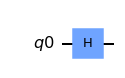

In [ ]:
sim = Aer.get_backend('aer_simulator')  # Define the simulator.

qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.h(0)  # Apply the Hadamard gate on qubit 0.
print(qc)  # Print the circuit.

'''
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.
'''

print(Statevector.from_instruction(qc))
qc.draw(output='mpl')  

    ┌─────────┐
q1: ┤ Ry(π/2) ├
    └─────────┘
Statevector([0.70710678+0.j, 0.70710678+0.j],
            dims=(2,))


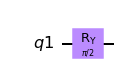

In [ ]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.ry(np.pi/2,0)  # Apply the RY(pi/2) gate on qubit 0.
print(qc)  # Print the circuit.

'''
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.
'''

print(Statevector.from_instruction(qc))
qc.draw(output='mpl')  

## $H|1\rangle = R_y(-\pi/2)|0\rangle = |-\rangle$

### **Matrix approach**

$$H |1\rangle = \frac{1}{\sqrt{2}} \begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix} \begin{bmatrix} 0 \\ 1 \end{bmatrix} =  \frac{1}{\sqrt{2}} \begin{bmatrix} 1*0 + 1*1 \\ 1*0 -1*1 \end{bmatrix} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 \\ -1 \end{bmatrix} =  \frac{1}{\sqrt{2}} \Bigg( \begin{bmatrix} 1 \\ 0 \end{bmatrix} - \begin{bmatrix} 0 \\ 1 \end{bmatrix} \Bigg) = \frac{1}{\sqrt{2}}\Big(|0\rangle-|1\rangle\Big) \equiv |-\rangle.$$

\begin{eqnarray}
R_y(\theta) \doteq \exp(-iY\theta/2) =  
\begin{bmatrix} cos(\theta/2) & -sin(\theta/2) \\ sin(\theta/2) & cos(\theta/2) \end{bmatrix}.
\end{eqnarray}

\begin{eqnarray}
R_y(-\pi/2)|0\rangle &=&  
\begin{bmatrix} 
cos(-\pi/4) & -sin(-\pi/4) \\ sin(-\pi/4) & cos(-\pi/4) \end{bmatrix} \begin{bmatrix} 1 \\ 0 
\end{bmatrix}
=
\begin{bmatrix} 
cos(-\pi/4) \\ sin(-\pi/4) 
\end{bmatrix}\\
&=&\begin{bmatrix} 
cos(\pi/4) \\ -sin(\pi/4) 
\end{bmatrix}
= \frac{1}{\sqrt(2)} 
\begin{bmatrix} 
1 \\ -1 
\end{bmatrix}
= |-\rangle.
\end{eqnarray}

One should note that cosine is an even function, $cos(-x)=cos(x)$, and sine is an odd function, $sin(-x) = -sin(x)$. Moreover, $sin(\pi/4) = cos(\pi/4)=\frac{1}{\sqrt{2}}$.


In [ ]:
# sine(pi/4) = cosine(pi/4)
np.sin(np.pi/4).round(9)  == np.cos(np.pi/4).round(9)

True

### **Verifying with NumPy:**

In [ ]:
had@one # H|1>.

array([[ 0.70710678],
       [-0.70710678]])

In [ ]:
ry_mpi2@zero # RY(-pi/2)|0>.

array([[ 0.70710678],
       [-0.70710678]])

### **Verifying with Qiskit:**

    ┌───┐┌───┐
q2: ┤ X ├┤ H ├
    └───┘└───┘
Statevector([ 0.70710678+0.j, -0.70710678+0.j],
            dims=(2,))


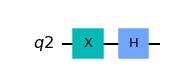

In [ ]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.x(0)  # Apply the Pauli-X gate on qubit 0.
qc.h(0)  # Apply the Hadamard gate on qubit 0.
print(qc)  # Print the circuit.

'''
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.
'''

print(Statevector.from_instruction(qc))
qc.draw(output='mpl')  

    ┌──────────┐
q3: ┤ Ry(-π/2) ├
    └──────────┘
Statevector([ 0.70710678+0.j, -0.70710678+0.j],
            dims=(2,))


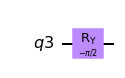

In [ ]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.ry(-np.pi/2,0)  # Apply the RY(-pi/2) gate on qubit 0.
print(qc)  # Print the circuit.

'''
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.
'''

print(Statevector.from_instruction(qc))
qc.draw(output='mpl')  

## $|++\rangle\langle ++|=(H\otimes H)|00\rangle\langle 00|(H\otimes H):$

**Verifying with NumPy:**

In [ ]:
(np.kron(plus.T,plus.T)@np.kron(plus,plus) == (np.kron(had,had))@zeros@(np.kron(had,had))).all()

True

In [ ]:
np.kron(plus.T,plus.T)@np.kron(plus,plus)

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

In [ ]:
(np.kron(had,had))@zeros@(np.kron(had,had))

array([[0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25],
       [0.25, 0.25, 0.25, 0.25]])

## $|--\rangle\langle --|=(H\otimes H)|11\rangle\langle 11|(H\otimes H):$

**Verifying with NumPy:**

In [ ]:
(np.kron(minus.T,minus.T)@np.kron(minus,minus) == (np.kron(had,had))@ones@(np.kron(had,had))).all()

True

In [ ]:
np.kron(minus.T,minus.T)@np.kron(minus,minus)

array([[ 0.25, -0.25, -0.25,  0.25],
       [-0.25,  0.25,  0.25, -0.25],
       [-0.25,  0.25,  0.25, -0.25],
       [ 0.25, -0.25, -0.25,  0.25]])

In [ ]:
(np.kron(had,had))@ones@(np.kron(had,had))

array([[ 0.25, -0.25, -0.25,  0.25],
       [-0.25,  0.25,  0.25, -0.25],
       [-0.25,  0.25,  0.25, -0.25],
       [ 0.25, -0.25, -0.25,  0.25]])

## $|+-\rangle\langle +-|=(H\otimes H)|01\rangle\langle 01|(H\otimes H):$

**Verifying with NumPy:**

In [ ]:
(np.kron(plus.T,minus.T)@np.kron(plus,minus) == (np.kron(had,had))@(zerone)@(np.kron(had,had))).all()

True

In [ ]:
np.kron(plus.T,minus.T)@np.kron(plus,minus)

array([[ 0.25, -0.25,  0.25, -0.25],
       [-0.25,  0.25, -0.25,  0.25],
       [ 0.25, -0.25,  0.25, -0.25],
       [-0.25,  0.25, -0.25,  0.25]])

In [ ]:
(np.kron(had,had))@(zerone)@(np.kron(had,had))

array([[ 0.25, -0.25,  0.25, -0.25],
       [-0.25,  0.25, -0.25,  0.25],
       [ 0.25, -0.25,  0.25, -0.25],
       [-0.25,  0.25, -0.25,  0.25]])

## $|-+\rangle\langle -+|=(H\otimes H)|10\rangle\langle 10|(H\otimes H):$

**Verifying with NumPy:**

In [ ]:
(np.kron(minus.T,plus.T)@np.kron(minus,plus) == (np.kron(had,had))@(onezero)@(np.kron(had,had))).all()

True

In [ ]:
np.kron(minus.T,plus.T)@np.kron(minus,plus)

array([[ 0.25,  0.25, -0.25, -0.25],
       [ 0.25,  0.25, -0.25, -0.25],
       [-0.25, -0.25,  0.25,  0.25],
       [-0.25, -0.25,  0.25,  0.25]])

In [ ]:
(np.kron(had,had))@(onezero)@(np.kron(had,had))

array([[ 0.25,  0.25, -0.25, -0.25],
       [ 0.25,  0.25, -0.25, -0.25],
       [-0.25, -0.25,  0.25,  0.25],
       [-0.25, -0.25,  0.25,  0.25]])

## $SH|0\rangle = R_x(-\pi/2)|0\rangle = |\oplus\rangle$



### **Verifying with NumPy:**

Note: here, ket vectors $|0 \rangle$ and $|1\rangle$ will be represented using 1-D numpy arrays.

In [ ]:
zero = np.array([1,0]) # 1-D NumPy array representing the state |0>.
one = np.array([0,1]) # 1-D NumPy array representing the state |1>.

zero.shape, one.shape

((2,), (2,))

In [ ]:
(phase@had)@zero # SH|0>.

array([0.70710678+0.j        , 0.        +0.70710678j])

In [ ]:
rx_mpi2@zero # RX(-pi/2)|0>.

array([0.70710678+0.j        , 0.        +0.70710678j])

### **Verifying with Qiskit:**

    ┌───┐┌───┐
q4: ┤ H ├┤ S ├
    └───┘└───┘
Statevector([0.70710678+0.j        , 0.        +0.70710678j],
            dims=(2,))


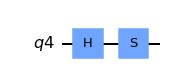

In [ ]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.h(0)  # Apply the Hadamard gate on qubit 0.
qc.s(0)  # Apply the S gate on qubit 0.
print(qc)  # Print the circuit.

'''
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.
'''

print(Statevector.from_instruction(qc))
qc.draw(output='mpl')  

    ┌──────────┐
q5: ┤ Rx(-π/2) ├
    └──────────┘
Statevector([0.70710678+0.j        , 0.        +0.70710678j],
            dims=(2,))


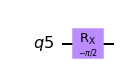

In [ ]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.rx(-np.pi/2,0)  # Apply the RX(-pi/2) gate on qubit 0.
print(qc)  # Print the circuit.

'''
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.
'''

print(Statevector.from_instruction(qc))
qc.draw(output='mpl')  

## $SH|1\rangle = R_x(\pi/2)|0\rangle = |\ominus\rangle$

### **Verifying with NumPy:**

In [ ]:
(phase@had)@one # SH|1>.

array([0.70710678+0.j        , 0.        -0.70710678j])

In [ ]:
rx_pi2@zero # RX(pi/2)|0>.

array([0.70710678+0.j        , 0.        -0.70710678j])

### **Verifying with Qiskit:**

    ┌───┐┌───┐┌───┐
q6: ┤ X ├┤ H ├┤ S ├
    └───┘└───┘└───┘
Statevector([0.70710678+0.j        , 0.        -0.70710678j],
            dims=(2,))


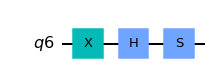

In [ ]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.x(0)  # Apply the Pauli-X gate on qubit 0.
qc.h(0)  # Apply the Hadamard gate on qubit 0.
qc.s(0)  # Apply the S gate on qubit 0.
print(qc)  # Print the circuit.

'''
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.
'''

print(Statevector.from_instruction(qc))
qc.draw(output='mpl') 

    ┌─────────┐
q7: ┤ Rx(π/2) ├
    └─────────┘
Statevector([0.70710678+0.j        , 0.        -0.70710678j],
            dims=(2,))


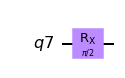

In [ ]:
qr = QuantumRegister(1)  # Define the number of qubits in the quantum circuit.
qc = QuantumCircuit(qr)
qc.rx(np.pi/2,0)  # Apply the RX(-pi/2) gate on qubit 0.
print(qc)  # Print the circuit.

'''
qc.save_statevector()  # Save the statevector.
qobj = assemble(qc)    # Create a Qobj from the circuit for the simulator to run.
result = sim.run(qobj).result() # Run the simulation and return the result.
out_state = result.get_statevector()
print(out_state)  # Print the output statevector.
'''

print(Statevector.from_instruction(qc))
qc.draw(output='mpl')  

## $X \otimes X = (X \otimes X)^{\dagger}:$

**Hermitian property of Pauli X.**

### **Matrix approach:**

\begin{eqnarray}
\sigma_{j=1} &\equiv& X \doteq
\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}.\\
X\otimes X &=&
\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}
\otimes 
\begin{pmatrix}
0 & 1 \\
1 & 0
\end{pmatrix}
=
\begin{bmatrix} 
0
\begin{bmatrix} 
0 & 1 \\
1 & 0
\end{bmatrix}
1
\begin{bmatrix} 
0 & 1 \\
1 & 0
\end{bmatrix}\\
1
\begin{bmatrix} 
0 & 1 \\
1 & 0
\end{bmatrix}
0
\begin{bmatrix} 
0 & 1 \\
1 & 0
\end{bmatrix} 
\end{bmatrix}
=
\begin{bmatrix} 
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0\\
1 & 0 & 0 & 0\\
\end{bmatrix}.\\
(X\otimes X)^{\dagger} &=& {\Bigg[(X\otimes X)^{T}\Bigg]}^* =
\begin{bmatrix} 
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0\\
1 & 0 & 0 & 0\\
\end{bmatrix}^*
=
\begin{bmatrix} 
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0\\
1 & 0 & 0 & 0\\
\end{bmatrix}
= X\otimes X.
\end{eqnarray}

Q.E.D.

### **Using NumPy:**

In [ ]:
(np.kron(sigma1, sigma1) == np.kron(sigma1, sigma1).conj().T).all() 

True

In [ ]:
np.kron(sigma1, sigma1)

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
np.kron(sigma1, sigma1).conj().T

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

# Verifying Quantum Circuits

- $ZZ(t)$, $XX(t)$, and $YY(t)$ gates.

## Short notes on linear algebra



Recall that Pauli operators $X, Y,$ and $Z$ are all represented by matrices that are both Hermitian and Unitary and, therefore, Involutory. Since they are Involutory, their eigenvalues are $\pm 1$. Moreover, Hermitian and Unitary matrices are Normal matrices. The converse is not true, i.e, Normal matrices are not always Hermitian and Unitary. A Normal matrix is Unitary iff all of its eigenvalues (the matrix spectrum) lie on the unit circle of the complex plane, i.e, they have modulus (absolute value) equal to one ($|\lambda|=1$), and hence they can be written in the form $\lambda=e^{i\theta}$ for some real-valued number $\theta$. And a Normal matrix is Hermitian iff all of its eigenvalues are real ($\lambda=\lambda^*$).

Recall from the spectral decomposition theorem for Normal matrices that any Normal operator $\hat{O}$ in a Hilbert space $\mathcal{H}$ of dimension $\dim \mathcal{H} =d$ is unitarily diagonalizable and has a spectral (eigenvalue) decomposition in terms of the outer product representation, and in the basis of its eigenvectors, of the form:

$$ \hat{O} = \sum_{j=1}^{d}= o_j P_{o_j} = \sum_{j=1}^{d} o_j |o_j \rangle \langle o_j|.$$

Where:

- $o_j$ and $P_{o_j}$ are the corresponding eigenvalue and projector operator of the observable $\hat{O}$, respectively. 

- $\{o_j\}|_{j=1}^d$ is a basis set of $d$ linearly independent orthonormal eigenvectors $|o_j\rangle$ of $\hat{O}$ with eigenvalue $o_j$.

Note that:

$$ \Bigg( \sum_{j=1}^{d} o_j |o_j \rangle \langle o_j| \Bigg) |o_k \rangle =  \sum_{j=1}^{d} o_j |o_j \rangle \delta_{jk}= o_k |o_k \rangle = \hat{O} |o_k \rangle.$$

Given the spectral decomposition theorem, it is possible to write the operator function (matrix function) on a Normal matrix $\hat{O}$ as follows:

$$f(\hat{O})= \sum_j f(o_j) |o_j\rangle \langle o_j|,$$

which is equivalent to (after writing $\hat{O} = UDU^{\dagger}$)

\begin{eqnarray}
f(\hat{O}) = Uf(D)U^{\dagger}.
\end{eqnarray}

For the exponential function over the field $\mathbb{C}^n$ of the complex numbers, this becomes:

$$ e^{i\theta\hat{O}} = \sum_{j=1}^n e^{i\theta o_j} |o_j\rangle \langle o_j| = e^{i\theta o_1} |o_{1}\rangle \langle o_{1}| + \cdots + e^{i\theta o_n} |o_{n}\rangle \langle o_{n}|.$$

To see this is true, recall that the eigenvalues of a matrix are multiplied by a scalar when the matrix is multiplied by the same scalar, while the eigenvectors are left unchanged. One can extend this identity to a tensor product of Normal operators noting that `the tensor product of two Hermitian operators is another Hermitian operator`. Recall that Hermitian and Unitary operators are also Normal operators.

## $ZZ(t)$ gate




In this section, the following gate will be verified:

$$ZZ(t)=e^{-itZ\otimes Z} = C_{x}^{01}\big(\mathbb{I}\otimes R_z(2t)\big)C_{x}^{01} = C_{x}^{01}\big(\mathbb{I}\otimes e^{-itZ}\big)C_{x}^{01}.$$



Recall that a general single-qubit standard rotation gate can be written as:

$$ R_{\hat{n}}(\theta) \doteq e^{\pm i(\hat{n} \cdot \vec{\sigma})\theta /2}= \cos(\theta/2) I \pm i \sin(\theta/2)(\hat{n}\cdot \hat{\sigma}),$$

and after defining $\theta \doteq 2t$, one has

\begin{eqnarray}
RZ(2t) \equiv R_z(2t)&=& R_{(0,0,1)}(2t) \doteq \exp(- iZ2t/2) = e^{-itZ} 
= cos(t)I -isin(t)Z = 
\begin{bmatrix} e^{- it} & 0 \\0 &  e^{it}
\end{bmatrix} = e^{- it}|0 \rangle\langle 0| + e^{it} |1 \rangle\langle 1|.
\end{eqnarray}

With that, the $e^{-itZZ}$ gate (a.k.a [RZZ](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RZZGate.html)(2t)) can be written as follows:

\begin{equation}
R_{zz}(2t)= \exp(-it Z\otimes Z)=cos\left(t\right)(\mathbb{I}_2\otimes \mathbb{I}_2)-isin\left(t\right)(Z\otimes Z).
\end{equation}

**1) The $e^{-itZ\otimes Z}$ gate is already diagonalized in the canonical basis a.k.a $Z$-basis.**

To see this is true, recall that Pauli operators are Normal operators, therefore, one can write the following spectral decomposition for the Pauli-$Z$ gate in the canonical basis: 

$$Z=\sum_{j=1}^{d} z_j |z_j \rangle \langle z_j|=|0\rangle\langle 0|-|1\rangle\langle 1|.$$

Note that the eigenvalues are $o_j = \pm 1$, since Pauli operators are represented by Involutory matrices. With that, one then has 

\begin{eqnarray}
Z\otimes Z &=& (|0\rangle\langle 0|-|1\rangle\langle 1|)\otimes(|0\rangle\langle 0|-|1\rangle\langle 1|) \tag{ZZ1}\\
&=& (|0\rangle\langle 0|) \otimes (|0\rangle\langle 0|) - (|0\rangle\langle 0|) \otimes (|1\rangle\langle 1|) - (|1\rangle\langle 1|)\otimes(|0\rangle\langle 0|) + (|1\rangle\langle 1|)\otimes(|1\rangle\langle 1|) \tag{ZZ2}\\
&=&|00\rangle\langle 00|-|01\rangle\langle 01|-|10\rangle\langle 10|+|11\rangle\langle 11| \tag{ZZ3} \\
&=& \begin{bmatrix} 
1 & 0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1  
\end{bmatrix}.
\end{eqnarray}

- Eq. ($ZZ2$) was obtained from Eq. ($ZZ1$) using the distributive property for matrices:

$$(A+B) \otimes (C+D)=A\otimes C+A\otimes D+B\otimes C+B\otimes D.$$

- Eq. ($ZZ3$) was obtained from Eq. ($ZZ2$) using:

$$|a\rangle \langle c| \otimes |b\rangle \langle d|  = (|a\rangle \otimes |b\rangle)(\langle c| \otimes \langle d|) \equiv |ab\rangle\langle cd|.$$

Finally, 

\begin{eqnarray}
e^{-itZ \otimes Z}&=&e^{-it}|00\rangle\langle 00|+ e^{it}|01\rangle\langle 01|+ e^{it}|10\rangle\langle 10|+e^{-it}|11\rangle\langle 11|\tag{ZZ4} \\
&=&e^{-it}\bigg(|00\rangle\langle 00|+|11\rangle\langle 11|\bigg)+e^{it}\bigg(|01\rangle\langle 01|+|10\rangle\langle 10|\bigg) \\
&=& 
\begin{bmatrix} 
e^{-it} & 0 & 0 & 0 \\ 0 & e^{it} & 0 & 0 \\ 0 & 0 & e^{it} & 0 \\ 0 & 0 & 0 & e^{-it}  
\end{bmatrix}.
\end{eqnarray}

- As for Eq. ($ZZ4$), it is the result of acting an operator function (in this case $e^{i\theta \hat{O}}$) on a Normal matrix (in this case $Z\otimes Z$) represented by its spectral decomposition, according to:

$$ e^{i\theta\hat{O}} = \sum_{j=1}^n e^{i\theta o_j} |o_j\rangle \langle o_j| = e^{i\theta o_1} |o_{1}\rangle \langle o_{1}| + \cdots + e^{i\theta o_n} |o_{n}\rangle \langle o_{n}|.$$

In another perspective, when the matrix is diagonal, the function acts on its diagonal entries.

**2) Computing the parity information by acting with the $ZZ$ operator.**

To build quantum circuits corresponding to unitary evolution operators from exponentials of the form $U=e^{-i\hat{H}\Delta t}$, one can use the parity trick (see Ref. [[1](#ref1)], Sec. 4.7.3). In this case, one can obtain Eq. ($ZZ4$) by computing the parity information, as follows:

\begin{eqnarray}
(Z\otimes Z)|00\rangle &=& |00\rangle, \\
(Z\otimes Z)|10\rangle &=& -|10\rangle, \\
(Z\otimes Z)|01\rangle &=& -|01\rangle, \\
(Z\otimes Z)|11\rangle &=& |11\rangle. \\
\end{eqnarray}

One can see that a minus sign (phase) is introduced whenever the basis state has odd parity (01 or 10). Therefore, in the computational basis, a phase shift will be applied to the system according to $e^{i\Delta t}$ if the parity of the $n$ qubits in the computational basis is odd, otherwise, the phase shift will be $e^{-i\Delta t}$ if the parity is even (see Ref. [[1](#ref1)], Sec. 4.7.3). With this result, one can write:

\begin{eqnarray}
e^{-itZ \otimes Z} &=& e^{-it}|00\rangle\langle 00| + e^{it}|01\rangle\langle 01| + e^{it}|10 \rangle\langle 10| + e^{-it}|11 \rangle\langle 11|.
\end{eqnarray}

**3) Implementing the CNOT gates and the $R_z(2t)$ gate for the parity computation circuit:**

\begin{eqnarray}
CX^{01}\big(\mathbb{I} \otimes R_z(2t)\big)CX^{01} =
CX^{01}\big(\mathbb{I} \otimes e^{-itZ}\big)CX^{01},
\end{eqnarray}

where it was used $RZ(2t) = e^{-itZ}$.

Using the equation for a generic CU gate, one can write $CX^{01} = \mathbb{I} \otimes |0\rangle\langle 0\rangle + X \otimes |1 \rangle \langle 1|$. However, in textbook convention the CNOT gate reads $CX^{01}=|0\rangle\langle 0|\otimes \mathbb{I} +|1\rangle\langle 1|\otimes X$. One then has

\begin{eqnarray}
CX^{01}\big(\mathbb{I} \otimes e^{-itZ}\big)CX^{01}=CX^{01}\big( \mathbb{I} \otimes e^{-itZ}\big)\big(|0\rangle\langle 0|\otimes \mathbb{I}  +|1\rangle\langle 1|\otimes X \big).
\end{eqnarray}

From here, the distributive property of matrix multiplication over matrix addition yelds:

$$\big(\mathbb{I}\otimes e^{-itZ}\big)\big(|0\rangle\langle 0|\otimes \mathbb{I} +|1\rangle\langle 1|\otimes X \big) = \big(\mathbb{I}\otimes e^{-itZ}\big) \big(|0\rangle\langle 0|\otimes \mathbb{I} \big) + \big(\mathbb{I} \otimes e^{-itZ}\big)\big(|1\rangle\langle 1|\otimes X \big).$$

Using $(A\otimes B)\cdot(C\otimes D)=A\cdot C\otimes B\cdot D$, the right hand side becomes:

$$\Bigg[(\mathbb{I} \cdot |0\rangle\langle 0|) \otimes (e^{-itZ} \cdot \mathbb{I})\Bigg] + \Bigg[ (\mathbb{I} \cdot |1\rangle\langle 1|) \otimes (e^{-itZ} \cdot X) \Bigg] = \Bigg(|0\rangle\langle 0|\otimes e^{-itZ} \Bigg) + \Bigg(|1\rangle\langle 1|\otimes e^{-itZ}X \Bigg) .$$ 

With that, one then has:

\begin{eqnarray}
CX^{01}\bigg(\mathbb{I}\otimes e^{-itZ}\bigg)CX^{01} &=& CX^{01}\bigg(|0\rangle\langle 0|\otimes e^{-itZ} +|1\rangle\langle 1|\otimes e^{-itZ}X \bigg) = \bigg(|0\rangle\langle 0|\otimes \mathbb{I} +|1\rangle\langle 1|\otimes X \bigg)\bigg(|0\rangle\langle 0|\otimes e^{-itZ} +|1\rangle\langle 1|\otimes e^{-itZ}X \bigg).
\end{eqnarray}

Once again, applying the distributive property over matrix addition, the last term becomes

\begin{eqnarray}
CX^{01}\bigg(\mathbb{I}\otimes e^{-itZ}\bigg)CX^{01} &=& \bigg(|0\rangle\langle 0|\otimes \mathbb{I} \Bigg)\bigg(|0\rangle\langle 0|\otimes e^{-itZ} \Bigg)+\bigg(|0\rangle\langle 0|\otimes \mathbb{I} \Bigg)\bigg(|1\rangle\langle 1|\otimes e^{-itZ}X \Bigg)\\
&+&\bigg(|1\rangle\langle 1|\otimes X\bigg)\bigg(|0\rangle\langle 0|\otimes e^{-itZ}\bigg)+\bigg(|1\rangle\langle 1|\otimes X\bigg)\bigg(|1\rangle\langle 1|\otimes e^{-itZ}X\bigg)\\
&=& \Bigg(|0\rangle\langle 0|0\rangle\langle 0| \otimes e^{-itZ}\Bigg)\Bigg(|0\rangle\langle 0|1\rangle\langle 1| \otimes e^{-itZ}X\Bigg)\Bigg(|1\rangle\langle 1|0\rangle\langle 0| \otimes Xe^{-itZ}\Bigg)\Bigg(|1\rangle\langle 1|1\rangle\langle 1| \otimes Xe^{-itZ}X\Bigg)\\
&=& \Bigg(|0\rangle\langle 0|\otimes e^{-itZ} \Bigg)+\Bigg(|1\rangle\langle 1|\otimes Xe^{-itZ}X \Bigg) \\ 
&=& \Bigg(|0\rangle\langle 0|\otimes (e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|)\Bigg) +\Bigg(|1\rangle\langle 1|\otimes X (e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|)X\Bigg) \\
&=&\Bigg(|0\rangle\langle 0|\otimes (e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|)\Bigg) +\Bigg(|1\rangle\langle 1|\otimes  (e^{-it}X|0\rangle\langle 0|X+e^{it}X|1\rangle\langle 1|X)\Bigg),
\end{eqnarray}

where it was used $\langle i|j\rangle = \delta_{ij}$ for a set of orthonormal eigenvectors, and $e^{-itZ}=e^{- it}|0 \rangle\langle 0| + e^{it} |1 \rangle\langle 1|$. 

To compute $\big(e^{-it}X|0\rangle\langle 0|X+e^{it}X|1\rangle\langle 1|X\big)$, one should note that 

\begin{eqnarray}
X|0\rangle &=& |1\rangle, \\
X|1\rangle &=& |0\rangle, \\
(A|\psi\rangle)^{\dagger} &=& |\psi\rangle^{\dagger} A^{\dagger} = \langle \psi| A^{\dagger}, \\
X^{\dagger}&=&X,\\
\langle 0| X &=& (X|0\rangle)^{\dagger} = (|1\rangle)^{\dagger} = \langle 1|,\\
\langle 1| X &=& (X|1\rangle)^{\dagger} = (|0\rangle)^{\dagger} = \langle 0|.
\end{eqnarray}

Finally,
\begin{eqnarray}
CX^{01}(\mathbb{I}\otimes e^{-itZ})CX^{01}&=& \Bigg(|0\rangle\langle 0|\otimes (e^{-it}|0\rangle\langle 0|+e^{it}|1\rangle\langle 1|)\Bigg) + \Bigg(|1\rangle\langle 1|\otimes (e^{-it}|1\rangle\langle 1|+e^{it}|0\rangle\langle 0|)\Bigg) \\
&=& \Bigg(e^{-it}|0\rangle\langle 0|\otimes|0\rangle\langle 0|+e^{it}|0\rangle\langle 0|\otimes|1\rangle\langle 1|\Bigg) + \Bigg(e^{-it}|1\rangle\langle 1|\otimes|1\rangle\langle 1|+e^{it}|1\rangle\langle 1|\otimes|0\rangle\langle 0|\Bigg) \\
&=& e^{-it}|00\rangle\langle 00| + e^{it}|01\rangle\langle 01| + e^{-it}|11\rangle\langle 11|+ e^{it}|10\rangle\langle 10| \\
&=& e^{-itZZ},
\end{eqnarray}

where it was used the left–distributive property $$A \otimes (B+C) = A\otimes B+A\otimes C,$$ and the identity $$(|a\rangle \langle c|) \otimes (|b\rangle \langle d|)=(|a\rangle \otimes |b\rangle)(\langle c| \otimes \langle d|) \equiv |ab\rangle \langle cd|.$$

Q.E.D.

## $XX(t)$ gate

One should note that $e^{-itXX}$ is shorthand for $e^{-itX \otimes X}.$ Recall that Pauli operators are all involutory operators, i.e, their eigenvalues are $o_j = \pm 1$. According to the spectral decomposition theorem for Normal matrices, one then has:

$$X = \sum_{j=1}^{d} x_j |x_j \rangle \langle x_j| = |+\rangle\langle +|-|-\rangle\langle -|,$$

where $$ |\pm\rangle \equiv \frac{1}{\sqrt{2}}(|0\rangle\pm|1\rangle) $$ 

denotes the two orthonormal eigenstates (eigenvectors) of the Pauli $X$-gate according to:

$$X |+\rangle = \frac{1}{\sqrt{2}}(X|0\rangle+X|1\rangle)=\frac{1}{\sqrt{2}}(|1\rangle+|0\rangle)=|+\rangle,$$
$$X |-\rangle = \frac{1}{\sqrt{2}}(X|0\rangle-X|1\rangle) =\frac{1}{\sqrt{2}}(|1\rangle-|0\rangle)=-|-\rangle.$$

With that, one gets:

\begin{eqnarray}
XX &\equiv& X\otimes X = (|+\rangle\langle +|-|-\rangle\langle -|)\otimes(|+\rangle\langle +|-|-\rangle\langle -|) \tag{XX1}\\
&=& (|+\rangle\langle +|) \otimes (|+\rangle\langle +|) - (|+\rangle\langle +|) \otimes (|-\rangle\langle -|) - (|-\rangle\langle -|)\otimes (|+\rangle\langle +|) + (|-\rangle\langle -|) \otimes (|-\rangle\langle -|) \tag{XX2} \\
&=& (|++\rangle\langle ++|)-(|+-\rangle\langle +-|)-(|-+\rangle\langle -+|)+(|--\rangle\langle --|) \tag{XX3} \\
\implies e^{-itX \otimes X}
&=&e^{-it}|++\rangle\langle ++|+ e^{-it}|--\rangle\langle --|+e^{it}|+-\rangle\langle +-|+ e^{it}|-+\rangle\langle -+|\tag{XX4} \\
&=&e^{-it}\bigg(|++\rangle\langle ++|+|--\rangle\langle --|\bigg)+e^{it}\bigg(|+-\rangle\langle +-|+|-+\rangle\langle -+|\bigg).
\end{eqnarray}

- Eq. ($XX2$) was obtained from Eq. ($XX1$) using the distributive property for matrices:

$$(A+B) \otimes (C+D)=A\otimes C+A\otimes D+B\otimes C+B\otimes D.$$

- Eq. ($XX3$) was obtained from Eq. ($XX2$) using:

$$|a\rangle \langle c| \otimes |b\rangle \langle d|  = (|a\rangle \otimes |b\rangle)(\langle c| \otimes \langle d|) \equiv |ab\rangle\langle cd|.$$

- Just as before, Eq. ($XX4$) is the result of acting an operator function (in this case $e^{i\theta \hat{O}}$) on a Normal matrix (in this case $X\otimes X$) represented by its corresponding spectral decomposition. 

As one can see, the $e^{-itX\otimes X}$ gate is not diagonalized in the $Z$-basis. Since measurements are computed in the $Z$-basis, one must apply a Hadamard gate to change between the $X$ and $Z$ bases according to

\begin{eqnarray}
|+\rangle &=& H|0\rangle = R_y(\pi/2)|0\rangle, \\
|-\rangle &=& H|1\rangle = R_y(-\pi/2)|0\rangle, \\
\langle +| &=& (|+\rangle)^{\dagger} = (H|0\rangle)^{\dagger} = (|0\rangle)^{\dagger}H^{\dagger} = \langle 0|H,\\
\langle -| &=& (|-\rangle)^{\dagger} == (H|1\rangle)^{\dagger} = (|1\rangle)^{\dagger}H^{\dagger} = \langle 1|H.
\end{eqnarray}

With that, and using $A |a\rangle \otimes B |b\rangle = (A\otimes B)(|a\rangle \otimes |b\rangle),$ one can write the respective outer products as follows:

\begin{eqnarray}
|++\rangle\langle ++| &=& (H|0\rangle \otimes H|0\rangle)(\langle 0| H \otimes \langle 0| H)\\
&=& \Bigg[(H \otimes H)(|0\rangle \otimes |0\rangle)\Bigg]\Bigg[(\langle 0| \otimes \langle 0|)(H \otimes H)\Bigg] \\
&=&(H\otimes H)|00\rangle\langle 00|(H\otimes H),\\
\end{eqnarray}

\begin{eqnarray}
|--\rangle\langle --| &=& (H|1\rangle \otimes H|1\rangle)(\langle 1| H\otimes \langle 1| H)\\
&=& \Bigg[(H \otimes H)(|1\rangle \otimes |1\rangle)\Bigg]\Bigg[(\langle 1| \otimes \langle 1|)(H \otimes H)\Bigg] \\
&=&(H\otimes H)|11\rangle\langle 11|(H\otimes H),
\end{eqnarray}

\begin{eqnarray}
|+-\rangle\langle +-| &=& (H|0\rangle \otimes H|1\rangle)(\langle 0| H \otimes \langle 1| H)\\
&=& \Bigg[(H \otimes H)(|0\rangle \otimes |1\rangle)\Bigg]\Bigg[(\langle 0| \otimes \langle 1|)(H \otimes H)\Bigg] \\
&=&(H\otimes H)|01\rangle\langle 01|(H\otimes H),
\end{eqnarray}

\begin{eqnarray}
|-+\rangle\langle -+| &=& (H|1\rangle \otimes H|0\rangle)(\langle 1| H \otimes \langle 0| H)\\
&=& \Bigg[(H \otimes H)(|1\rangle \otimes |0\rangle)\Bigg]\Bigg[(\langle 1| \otimes \langle 0|)(H \otimes H)\Bigg] \\
&=&(H\otimes H)|10\rangle\langle 10|(H\otimes H).
\end{eqnarray}

Finally,

\begin{eqnarray}
e^{-itX \otimes X} &=& e^{-it}\Bigg[(H\otimes H)|00\rangle\langle 00|(H\otimes H)+(H\otimes H)|11\rangle\langle 11|(H\otimes H)\Bigg]+e^{it}\Bigg[(H\otimes H)|01\rangle\langle 01|(H\otimes H)+(H\otimes H)|10\rangle\langle 10|(H\otimes H)\Bigg] \\
&=& (H\otimes H)\Bigg[e^{-it}\Bigg(|00\rangle\langle 00|+|11\rangle\langle 11|\Bigg)+e^{it}\Bigg(|01\rangle\langle 01|+|10\rangle\langle 10|\Bigg)\Bigg](H\otimes H)\\
&=& (H\otimes H)e^{-itZ\otimes Z}(H\otimes H) \\
&=& (H\otimes H)C_{x}^{01}\big(\mathbb{I}\otimes e^{-itZ}\big)C_{x}^{01}(H\otimes H) \\
&=& (H\otimes H)C_{x}^{01}\big(\mathbb{I}\otimes R_Z(2t)\big)C_{x}^{01}(H\otimes H),
\end{eqnarray}

where it was used the previously obtained decomposition of the $ZZ(t)$ gate, given by

\begin{eqnarray}
ZZ(t)=e^{-itZ\otimes Z} &=& e^{-it}\Bigg(|00\rangle\langle 00|+|11\rangle\langle 11|\Bigg)+e^{it}\Bigg(|01\rangle\langle 01|+|10\rangle\langle 10|\Bigg)=C_{x}^{01}\big(\mathbb{I}\otimes e^{-itZ}\big)C_{x}^{01},
\end{eqnarray}

and the fact that $e^{-itZ} = R_z(2t)$.

Q.E.D.

## $YY(t)$ gate

One should note that $e^{-itYY}$ is shorthand for $e^{-itY \otimes Y}$. Following the same thought process as before, one writes the spectral decomposition of the Pauli operator $Y$ in the basis of its eigenvectors:

$$Y=\sum_{j=1}^{d} y_j |y_j \rangle \langle y_j|=|\oplus\rangle\langle \oplus|-|\ominus\rangle\langle \ominus|,$$

where

\begin{eqnarray}
|+y\rangle &\equiv& |\oplus\rangle \doteq \frac{1}{\sqrt{2}}(|0\rangle+i|1\rangle), \\
|-y\rangle &\equiv& |\ominus\rangle \doteq \frac{1}{\sqrt{2}}(|0\rangle-i|1\rangle),
\end{eqnarray}

denotes the two orthonormal eigenstates (eigenvectors) of the Pauli $Y$-gate. 

With that, one has

\begin{eqnarray}
YY &\equiv& Y \otimes Y = (|\oplus\rangle\langle \oplus|-|\ominus\rangle\langle \ominus|)\otimes(|\oplus\rangle\langle \oplus|-|\ominus\rangle\langle \ominus|) \tag{YY1}\\
&=& (|\oplus\rangle\langle \oplus|) \otimes (|\oplus\rangle\langle \oplus|) - (|\oplus\rangle\langle \oplus|) \otimes (|\ominus\rangle\langle \ominus|) - (|\ominus\rangle\langle \ominus|)\otimes(|\oplus\rangle\langle \oplus|) + (|\ominus\rangle\langle \ominus|)\otimes(|\ominus\rangle\langle \ominus|) \tag{YY2}\\
&=&|\oplus\oplus\rangle\langle \oplus\oplus|-|\oplus\ominus\rangle\langle \oplus\ominus|-|\ominus\oplus\rangle\langle \ominus\oplus|+|\ominus\ominus\rangle\langle \ominus\ominus| \tag{YY3}.
\end{eqnarray}

- Eq. ($YY2$) was obtained from Eq. ($YY1$) using the distributive property for matrices:

$$(A+B) \otimes (C+D)=A\otimes C+A\otimes D+B\otimes C+B\otimes D.$$

- Eq. ($YY3$) was obtained from Eq. ($YY2$) using:

$$|a\rangle \langle c| \otimes |b\rangle \langle d|  = (|a\rangle \otimes |b\rangle)(\langle c| \otimes \langle d|) \equiv |ab\rangle\langle cd|.$$

Henceforth, 

\begin{eqnarray}
e^{-itY \otimes Y}&=&e^{-it}|\oplus\oplus\rangle\langle \oplus\oplus|+ e^{it}|\oplus\ominus\rangle\langle \oplus\ominus|+ e^{it}|\ominus\oplus\rangle\langle \ominus\oplus|+e^{-it}|\ominus\ominus\rangle\langle \ominus\ominus|\tag{YY4} \\
&=&e^{-it}\Bigg(|\oplus\oplus\rangle\langle \oplus\oplus|+|\ominus\ominus\rangle\langle \ominus\ominus|\Bigg) + e^{it}\Bigg(|\oplus\ominus\rangle\langle \oplus\ominus|+|\ominus\oplus\rangle\langle \ominus\oplus|\Bigg).
\end{eqnarray}

- Once more, Eq. ($YY4$) is the result of acting an operator function (in this case $e^{i\theta \hat{O}}$) on a Normal matrix (in this case $Y\otimes Y$) with the spectral decomposition, according to:

$$ e^{i\theta\hat{O}} = \sum_{j=1}^n e^{i\theta o_j} |o_j\rangle \langle o_j| = e^{i\theta o_1} |o_{1}\rangle \langle o_{1}| + \cdots + e^{i\theta o_n} |o_{n}\rangle \langle o_{n}|.$$

As one can see, the $e^{-itY\otimes Y}$ gate is not diagonalized in the $Z$-basis. Since measurements are computed in the $Z$-basis, the next step is to apply a basis change, as follows:

\begin{eqnarray}
|\oplus\rangle &=& SH|0\rangle = R_x(-\pi/2)|0\rangle, \\
|\ominus\rangle &=& SH|1\rangle = R_x(\pi/2)|0\rangle, \\
\langle \oplus| &=& (|\oplus\rangle)^{\dagger} = (SH|0\rangle)^{\dagger} = (|0\rangle)^{\dagger} (SH)^{\dagger} = \langle 0| H^{\dagger}S^{\dagger}=\langle 0|HS^{\dagger},\\
\langle \ominus| &=& (|\ominus\rangle)^{\dagger} = (SH|1\rangle)^{\dagger} = (|1\rangle)^{\dagger} (SH)^{\dagger} = \langle 1| H^{\dagger}S^{\dagger}=\langle 1|HS^{\dagger}.
\end{eqnarray}

With that, and using $A |a\rangle \otimes B |b\rangle = (A\otimes B)(|a\rangle \otimes |b\rangle),$ one can write the respective outer products as follows:

\begin{eqnarray}
|\oplus\oplus\rangle\langle \oplus\oplus| &=& (SH|0\rangle \otimes SH|0\rangle)(\langle 0| HS^{\dagger} \otimes \langle 0| HS^{\dagger})\\
&=& \Bigg[(SH \otimes SH)(|0\rangle \otimes |0\rangle)\Bigg]\Bigg[(\langle 0| \otimes \langle 0|)(HS^{\dagger} \otimes HS^{\dagger})\Bigg] \\
&=&(S\otimes S)(H\otimes H)|00\rangle\langle 00|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}),
\end{eqnarray}

\begin{eqnarray}
|\ominus\ominus\rangle\langle \ominus\ominus| &=& (SH|1\rangle \otimes SH|1\rangle)(\langle 1| HS^{\dagger} \otimes \langle 1| HS^{\dagger})\\
&=& \Bigg[(SH \otimes SH)(|1\rangle \otimes |1\rangle)\Bigg]\Bigg[(\langle 1| \otimes \langle 1|)(HS^{\dagger} \otimes HS^{\dagger})\Bigg] \\
&=&(S\otimes S)(H\otimes H)|11\rangle\langle 11|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}),
\end{eqnarray}

\begin{eqnarray}
|\oplus\ominus\rangle\langle \oplus\ominus| &=& (SH|0\rangle \otimes SH|1\rangle)(\langle 0| HS^{\dagger} \otimes \langle 1| HS^{\dagger})\\
&=& \Bigg[(SH \otimes SH)(|0\rangle \otimes |1\rangle)\Bigg]\Bigg[(\langle 0| \otimes \langle 1|)(HS^{\dagger} \otimes HS^{\dagger})\Bigg] \\
&=&(S\otimes S)(H\otimes H)|01\rangle\langle 01|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}),
\end{eqnarray}

\begin{eqnarray}
|\ominus\oplus\rangle\langle \ominus\oplus| &=& (SH|1\rangle \otimes SH|0\rangle)(\langle 1| HS^{\dagger} \otimes \langle 0| HS^{\dagger})\\
&=& \Bigg[(SH \otimes SH)(|1\rangle \otimes |0\rangle)\Bigg]\Bigg[(\langle 1| \otimes \langle 0|)(HS^{\dagger} \otimes HS^{\dagger})\Bigg] \\
&=&(S\otimes S)(H\otimes H)|10\rangle\langle 10|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}).
\end{eqnarray}

Finally,

\begin{eqnarray}
e^{-itY\otimes Y} &=& e^{-it}\Bigg((S\otimes S)(H\otimes H)|00\rangle\langle 00|(H\otimes H)(S^{\dagger}\otimes S^{\dagger})+(S\otimes S)(H\otimes H)|11\rangle\langle 11|(H\otimes H)(S^{\dagger}\otimes S^{\dagger})\Bigg) \\
&+& e^{it}\Bigg((S\otimes S)(H\otimes H)|01\rangle\langle 01|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) + (S\otimes S)(H\otimes H)|10\rangle\langle 10|(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \Bigg)\\
&=& (S\otimes S)(H\otimes H)\Bigg[e^{-it}\Bigg(|00\rangle\langle 00|+|11\rangle\langle 11|\Bigg)+e^{it}\Bigg(|01\rangle\langle 01|+|10\rangle\langle 10|\Bigg)\Bigg](H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \\
& =& (S\otimes S)(H\otimes H)e^{-itZ \otimes Z}(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \\
&=&(S\otimes S)(H\otimes H)C_{x}^{01}\big(\mathbb{I}\otimes e^{-itZ}\big)C_{x}^{01}(H\otimes H)(S^{\dagger}\otimes S^{\dagger}) \\
&=&(S\otimes S)(H\otimes H)C_{x}^{01}\big(\mathbb{I}\otimes R_z(2t)\big)C_{x}^{01}(H\otimes H)(S^{\dagger}\otimes S^{\dagger}).
\end{eqnarray}

Where it was used the previously obtained result for the decomposition of the $ZZ(t)=e^{-itZ\otimes Z}$ gate and the equality $e^{-itZ} = R_z(2t)$.

Q.E.D.

# &nbsp; <a href="#"><img valign="middle" height="45px" src="https://img.icons8.com/book" width="45" hspace="0px" vspace="0px"></a> References

[1] Nielsen MA, Chuang IL. 2010. Quantum Computation and Quantum Information. New York: [Cambridge Univ. Press.](https://doi.org/10.1017/CBO9780511976667) 10th Anniv. Ed.  

[2] Horn, R., & Johnson, C. (1991). Frontmatter. In Topics in Matrix Analysis (pp. I-Iv). [Cambridge: Cambridge University Press](https://www.cambridge.org/core/books/topics-in-matrix-analysis/B988495A235F1C3406EA484A2C477B03).

